# Assignment: Dyna-Q and Dyna-Q+

## The Shortcut Maze Environment

In the following Code, only in assignment.ipynb is my written code, I've labelled all the cells that are done by me as:
# -----------
# Done By Me
# -----------

And the provided cells with:
# ---------------
# Provided Code
# ---------------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import jdc
import os
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

## Section 1: Dyna-Q

In [3]:
# ---------------
# Provided Code
# ---------------

class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        # First, we get the relevant information from agent_info 
        # NOTE: we use np.random.RandomState(seed) to set the two different RNGs
        # for the planner and the rest of the code
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, etc.
        # A simple way to implement the model is to have a dictionary of dictionaries, 
        #        mapping each state to a dictionary which maps actions to (reward, next state) tuples.
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {} # model is a dictionary of dictionaries, which maps states to actions to 
                        # (reward, next_state) tuples

In [4]:
%%add_to DynaQAgent

# -----------
# Done By Me
# -----------

def update_model(self, past_state, past_action, state, reward):
    """updates the model 
    
    Args:
        past_state       (int): s
        past_action      (int): a
        state            (int): s'
        reward           (int): r
    Returns:
        Nothing
    """
    # Update the model with the (s,a,s',r) tuple (1~4 lines)
    
    # ----------------
    
    # First check if the state is in the model

    if past_state in self.model:
        if past_action in self.model[past_state]:
            # Update already existing action and state
            self.model[past_state][past_action]=(state,reward)
        else:
            # State exist but action doesn't
            self.model[past_state].update({past_action:(state,reward)})
    else: 
        # state doesn't exist
        self.model.update({past_state: {past_action: (state,reward)}})
            
            
    return None
    
    # ----------------

Next, you will implement the planning step, the crux of the Dyna-Q algorithm. You shall be calling this `planning_step` method at every timestep of every trajectory.

In [5]:
%%add_to DynaQAgent

# -----------
# Done By Me
# -----------

def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """
    
    # The indirect RL step:
    # - Choose a state and action from the set of experiences that are stored in the model. (~2 lines)
    # - Query the model with this state-action pair for the predicted next state and reward.(~1 line)
    # - Update the action values with this simulated experience.                            (2~4 lines)
    # - Repeat for the required number of planning steps.
    #
    # Note that the update equation is different for terminal and non-terminal transitions. 
    # To differentiate between a terminal and a non-terminal next state, assume that the model stores
    # the terminal state as a dummy state like -1
    #
    # Important: remember you have a random number generator 'planning_rand_generator' as 
    #     a part of the class which you need to use as self.planning_rand_generator.choice()
    #     For the sake of reproducibility and grading, *do not* use anything else like 
    #     np.random.choice() for performing search control.

    # ----------------
    for i in range(self.planning_steps):
        
        state= self.planning_rand_generator.choice(list(self.model.keys()))
        action= self.planning_rand_generator.choice(list(self.model[state].keys()))

        next_state,reward=self.model[state][action]

        if next_state==-1:
            
            self.q_values[state][action]+=self.step_size * (reward-self.q_values[state,action])
        else:
            
            self.q_values[state,action]+= self.step_size * (reward + self.gamma * np.amax(self.q_values[next_state,:]
                                                                                   - self.q_values[state,action]))
        
    
    
    # ----------------

Now before you move on to implement the rest of the agent methods, here are the helper functions that you've used in the previous assessments for choosing an action using an $\epsilon$-greedy policy.

In [6]:
%%add_to DynaQAgent

# ---------------
# Done By Me
# ---------------

def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [7]:
%%add_to DynaQAgent

# -----------
# Done By Me
# -----------

def agent_start(self, state):
    """The first method called when the experiment starts, 
    called after the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) the first action the agent takes.
    """
    
    # given the state, select the action using self.choose_action_egreedy()), 
    # and save current state and action (~2 lines)
    ### self.past_state = ?
    ### self.past_action = ?

    # ----------------
    action=self.choose_action_egreedy(state)
    self.past_action=action
    self.past_state=state
    
    # ----------------
    
    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.

    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent takes given this state.
    """
    
    # - Direct-RL step (~1-3 lines)
    # - Model Update step (~1 line)
    # - `planning_step` (~1 line)
    # - Action Selection step (~1 line)
    # Save the current state and action before returning the action to be performed. (~2 lines)

    # ----------------
    past_state=self.past_state
    past_action=self.past_action

    
    future_reward=reward + self.gamma * np.max(self.q_values[state])
    
    self.q_values[past_state,past_action]+=self.step_size * (future_reward - self.q_values[past_state,past_action])
        
    self.update_model( past_state, past_action, state, reward)
    
    self.planning_step()
    
    self.past_state=state
    
    self.past_action=self.choose_action_egreedy(state)
    
    
    
    
    # ----------------
    
    return self.past_action

def agent_end(self, reward):
    """Called when the agent terminates.

    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    
    # - Direct RL update with this final transition (1~2 lines)
    # - Model Update step with this final transition (~1 line)
    # - One final `planning_step` (~1 line)
    #
    # Note: the final transition needs to be handled carefully. Since there is no next state, 
    #       you will have to pass a dummy state (like -1), which you will be using in the planning_step() to 
    #       differentiate between updates with usual terminal and non-terminal transitions.

    # ----------------
    
    self.q_values[self.past_state,self.past_action]+=self.step_size * (reward - self.q_values[self.past_state,self.past_action])
    self.update_model(self.past_state,self.past_action,-1,reward)

    
    self.planning_step()
    
    
    # ----------------

### Experiment(s): Dyna-Q agent in the _changing_ maze environment 

In [8]:
# ---------------
# Provided Code
# ---------------

def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 54))  # For saving the number of
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 54))   #     state-visitations 
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   # For saving the cumulative reward
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs. 

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  # We start the experiment. We'll be collecting the 
                is_terminal = False            # state-visitation counts to visiualize the learned policy
                if num_steps < env_parameters["change_at_n"]: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()  
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    
    return log_data

def plot_cumulative_reward(data_all, item_key, y_key, y_axis_label, legend_prefix, title):
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [9]:
# ---------------
# Provided Code
# ---------------

def run_experiment_only_cumulative_reward(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    epsilons = agent_parameters['epsilons']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "planning_steps": agent_parameters["planning_steps"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    log_data = {'epsilons' : epsilons} 
    cum_reward_all = np.zeros((len(epsilons), num_runs, num_max_steps))

    for eps_idx, epsilon in enumerate(epsilons):

        print('Agent : Dyna-Q, epsilon : %f' % epsilon)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["epsilon"] = epsilon

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                rl_glue.rl_start()  # We start the experiment
                is_terminal = False

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step and return
                    # the reward, and action taken.
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[eps_idx][run][num_steps] = cum_reward

    log_data['cum_reward_all'] = cum_reward_all
    return log_data

Agent : Dyna-Q, epsilon : 0.000000


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


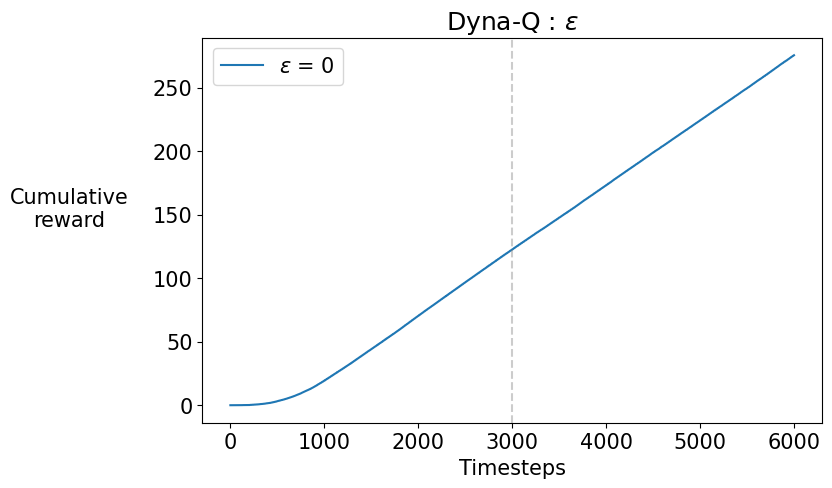

In [10]:
# ---------------
# Provided Code
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "step_size" : 0.1,
    "planning_steps" : 10,
    "epsilons": [0]    # The list of epsilons we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

data = run_experiment_only_cumulative_reward(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_cumulative_reward(data, 'epsilons', 'cum_reward_all', 'Cumulative\nreward', r'$\epsilon$ = ', r'Dyna-Q : $\epsilon$')

## Section 2: Dyna-Q+

The motivation behind Dyna-Q+ is to give a bonus reward for actions that haven't been tried for a long time, since there is a greater chance that the dynamics for that actions might have changed.

In particular, if the modeled reward for a transition is $r$, and the transition has not been tried in $\tau(s,a)$ time steps, then planning updates are done as if that transition produced a reward of $r + \kappa \sqrt{ \tau(s,a)}$, for some small $\kappa$. 

Let's implement that!

Based on your `DynaQAgent`, create a new class `DynaQPlusAgent` to implement the aforementioned exploration heuristic. Additionally :
1. actions that had never been tried before from a state should now be allowed to be considered in the planning step,
2. and the initial model for such actions is that they lead back to the same state with a reward of zero.

At this point, you might want to refer to the video lectures and [Section 8.3](http://www.incompleteideas.net/book/RLbook2018.pdf#page=188) of the RL textbook for a refresher on Dyna-Q+.

As usual, let's break this down in pieces and do it one-by-one.

First of all, check out the `agent_init` method below. In particular, pay attention to the attributes which are new to `DynaQPlusAgent`â€“ state-visitation counts $\tau$ and the scaling parameter $\kappa$ â€“ because you shall be using them later. 

In [11]:
# ---------------
# Done By Me
# ---------------

class DynaQPlusAgent(BaseAgent):
    
    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction
                kappa (float): The scaling factor for the reward bonus

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        # First, we get the relevant information from agent_info 
        # Note: we use np.random.RandomState(seed) to set the two different RNGs
        # for the planner and the rest of the code
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)
        self.kappa = agent_info.get("kappa", 0.001)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, tau, etc.
        # The visitation-counts can be stored as a table as well, like the action values 
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.tau = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

Now first up, implement the `update_model` method. Note that this is different from Dyna-Q in the aforementioned way.


In [12]:
%%add_to DynaQPlusAgent

# -----------
# Done By Me
# -----------

def update_model(self, past_state, past_action, state, reward):
    """updates the model 

    Args:
        past_state  (int): s
        past_action (int): a
        state       (int): s'
        reward      (int): r
    Returns:
        Nothing
    """

    # Recall that when adding a state-action to the model, if the agent is visiting the state
    #    for the first time, then the remaining actions need to be added to the model as well
    #    with zero reward and a transition into itself.
    #
    # Note: do *not* update the visitation-counts here. We will do that in `agent_step`.
    #
    # (3 lines)

    if past_state not in self.model:
        self.model[past_state] = {past_action : (state, reward)}
        # ----------------
        for action in self.actions:
            if action != past_action:
                # If this action hasn't been yet explored. 
                self.model[past_state][action]=(past_state,0)
        
        # ----------------
    else:
        self.model[past_state][past_action] = (state, reward)
    

Next, you will implement the `planning_step()` method. This will be very similar to the one you implemented in `DynaQAgent`, but here you will be adding the exploration bonus to the reward in the simulated transition.

In [13]:
%%add_to DynaQPlusAgent

# -----------
# Done By Me
# -----------

def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """

    # The indirect RL step:
    # - Choose a state and action from the set of experiences that are stored in the model. (~2 lines)
    # - Query the model with this state-action pair for the predicted next state and reward.(~1 line)
    # - **Add the bonus to the reward** (~1 line)
    # - Update the action values with this simulated experience.                            (2~4 lines)
    # - Repeat for the required number of planning steps.
    #
    # Note that the update equation is different for terminal and non-terminal transitions. 
    # To differentiate between a terminal and a non-terminal next state, assume that the model stores
    # the terminal state as a dummy state like -1
    #
    # Important: remember you have a random number generator 'planning_rand_generator' as 
    #     a part of the class which you need to use as self.planning_rand_generator.choice()
    #     For the sake of reproducibility and grading, *do not* use anything else like 
    #     np.random.choice() for performing search control.

    # ----------------
    for i in range(self.planning_steps):
        state=self.planning_rand_generator.choice(list(self.model.keys()))
        action=self.planning_rand_generator.choice(list(self.model[state].keys()))
        next_state,reward=self.model[state][action]
        
        reward = reward + self.kappa * np.sqrt(self.tau[state,action])
        
        if next_state==-1:
            
            self.q_values[state,action] += self.step_size * (reward - self.q_values[state,action])
            
        else:
            reward += self.gamma * np.max(self.q_values[next_state])
            
            self.q_values[state,action] += self.step_size * (reward - self.q_values[state,action])
            
    
    # ----------------

Again, before you move on to implement the rest of the agent methods, here are the couple of helper functions that you've used in the previous assessments for choosing an action using an $\epsilon$-greedy policy.

In [14]:
%%add_to DynaQPlusAgent

# ---------------
# Done By ME
# ---------------

def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

Now implement the rest of the agent-related methods, namely `agent_start`, `agent_step`, and `agent_end`. Again, these will be very similar to the ones in the `DynaQAgent`, but you will have to think of a way to update the counts since the last visit.

In [15]:
%%add_to DynaQPlusAgent

# -----------
# Done By Me
# -----------
    
def agent_start(self, state):
    """The first method called when the experiment starts, called after
    the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) The first action the agent takes.
    """
    
    # given the state, select the action using self.choose_action_egreedy(), 
    # and save current state and action (~2 lines)
    ### self.past_state = ?
    ### self.past_action = ?
    # Note that the last-visit counts are not updated here.
    
    # ----------------
    # your code here
    action=self.choose_action_egreedy(state)
    self.past_state=state
    self.past_action=action
    
    # ----------------
    
    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent is taking.
    """  
    
    # Update the last-visited counts (~2 lines)
    # - Direct-RL step (1~3 lines)
    # - Model Update step (~1 line)
    # - `planning_step` (~1 line)
    # - Action Selection step (~1 line)
    # Save the current state and action before returning the action to be performed. (~2 lines)
    
    # ----------------
    past_state=self.past_state
    past_action=self.past_action
    
    self.tau+=1
    self.tau[self.past_state,self.past_action]=0
    
    future_reward=reward + self.gamma * np.max(self.q_values[state])
    
    self.q_values[past_state,past_action]+= self.step_size * (future_reward - self.q_values[past_state,past_action])
    self.update_model(past_state,past_action,state,reward)
    
    self.planning_step()
    self.past_state=state
    self.past_action=self.choose_action_egreedy(state)
    
    # ----------------
    
    return self.past_action

def agent_end(self, reward):
    """Called when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    # Again, add the same components you added in agent_step to augment Dyna-Q into Dyna-Q+
    
    # ----------------
    self.tau += 1
    self.tau[self.past_state][self.past_action] = 0

    self.q_values[self.past_state,self.past_action]+=self.step_size * (reward - self.q_values[self.past_state,self.past_action])
    self.update_model(self.past_state,self.past_action,-1,reward)
    
    self.planning_step()
    
    
    # ----------------

### Experiment: Dyna-Q+ agent in the _changing_ environment

Okay, now we're ready to test our Dyna-Q+ agent on the Shortcut Maze. As usual, we will average the results over 30 independent runs of the experiment.

In [16]:
# ---------------
# Provided Code
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.5,
    "planning_steps" : [50]      
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQPlusAgent          # The agent

data_qplus = run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")

Planning steps :  50


100%|██████████| 30/30 [01:45<00:00,  3.52s/it]


In [20]:
# ---------------
# Provided Code
# ---------------

def plot_cumulative_reward_comparison(data1, data2):

    cum_reward_q = data1['cum_reward_all'][0]
    cum_reward_qPlus = data2['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

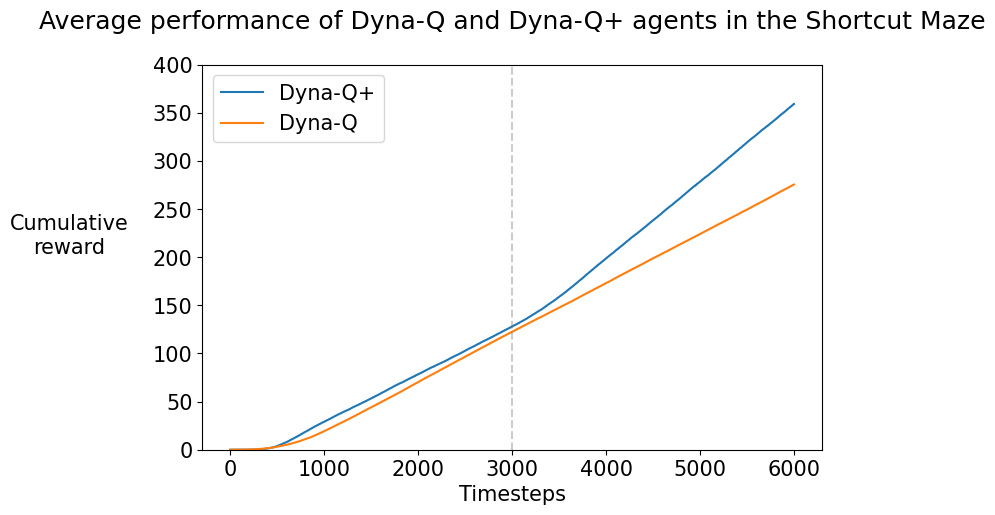

In [21]:
# ---------------
# Provided Code
# ---------------

plot_cumulative_reward_comparison(data, data_qplus)

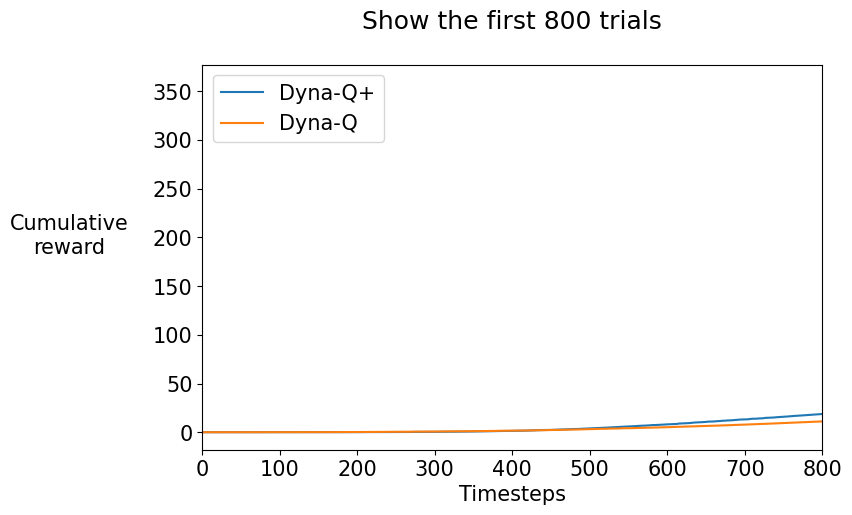

In [19]:
def plot_cumulative_reward_comparison(data1, data2):

    cum_reward_q = data1['cum_reward_all'][0]
    cum_reward_qPlus = data2['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Show the first 800 trials\n')
    plt.xlim(0,800)
    plt.show()
    
plot_cumulative_reward_comparison(data, data_qplus)